In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib.resources import files

import pandas as pd
import seaborn as sns

sns.set()

DATA_DIR = files("biobank_olink.data")

In [3]:
cov_df = pd.read_csv(DATA_DIR / "BP_cov.zip", sep="\t", index_col="eid")
cat_cols = ["Sex", "Smokinstatus", "HTNgroup"]
reg_cols = list(cov_df.columns.difference(cat_cols))
print(f"Original cov shape: {cov_df.shape}")
ol_df = pd.read_csv(DATA_DIR / "olink_data_ins0.csv", index_col=0)
print(f"Original ol shape: {ol_df.shape}")
eids = cov_df.index.intersection(ol_df.index)
cov_df = cov_df.loc[eids]
print(f"New cov shape: {cov_df.shape}")
ol_df = ol_df.loc[cov_df.index]
print(f"New ol shape: {ol_df.shape}")

Original cov shape: (409519, 10)
Original ol shape: (52704, 1463)
New cov shape: (43509, 10)
New ol shape: (43509, 1463)


In [4]:
import numpy as np

replace_comma_with_dot_if_str = lambda x: x.replace(",", ".") if isinstance(x, str) else x
cols = ["BMI", "SBP", "DBP", "PP"]
cov_df[cols] = cov_df[cols].applymap(replace_comma_with_dot_if_str)
cov_df.replace(" ", np.nan, inplace=True)
cov_df = cov_df.astype(float)
cov_df.loc[cov_df.HTNgroup == 4, "HTNgroup"] = np.nan

In [ ]:
import matplotlib.pyplot as plt


def plot_histograms(df):
    grid_size = int(np.ceil(np.sqrt(len(df.columns))))

    plt.figure(figsize=(6 * grid_size, 6 * grid_size))

    for index, column in enumerate(df.columns):
        plt.subplot(grid_size, grid_size, index + 1)
        sns.histplot(data=df, x=column, kde=False, bins=30, hue=cov_df.Sex.values.astype(str))
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(DATA_DIR / f"figs/histograms_{i}_{i + 100}.png")


for i in range(0, len(ol_df.columns), 100):
    plot_histograms(ol_df.iloc[:, i:i + 100])

In [26]:
cov_df.HTNgroup.value_counts()

HTNgroup
0.0    17874
1.0    12865
2.0     9722
Name: count, dtype: int64

/home/prenc/.miniconda3/envs/biobank_olink/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


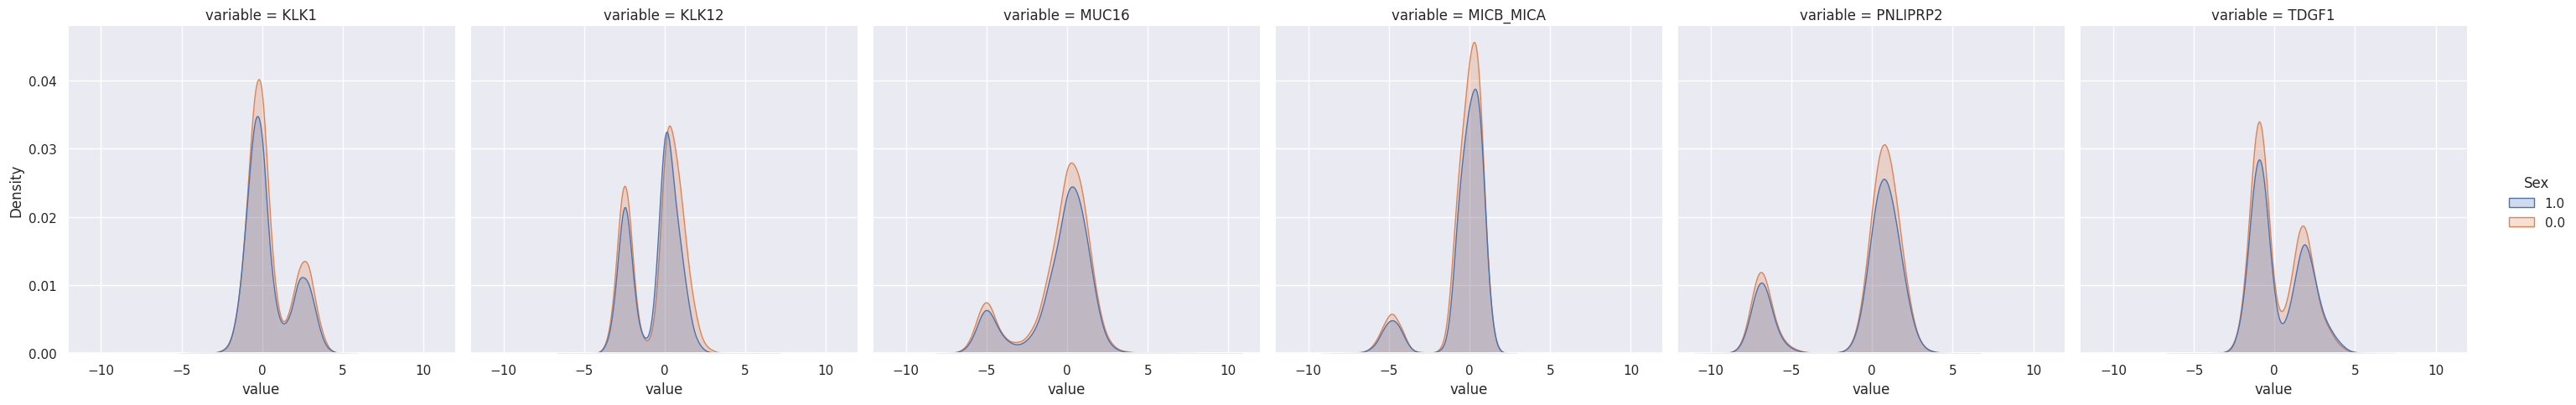

In [32]:
biomarkers = ["KLK1", "KLK12", "MUC16", "MICB_MICA",
              "PNLIPRP2", "TDGF1"]
data = ol_df.loc[:, biomarkers].melt(ignore_index=False)
sns.displot(data=data.reset_index(), x="value", col="variable",
            hue=cov_df.Sex[data.index].reset_index(drop=True).astype(str), kind="kde", fill=True)